# Imports

In [ ]:
import kagglehub

path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ai-vs-human-text


# Getting basic statistics about the dataset

I am trying to see common properties about the dataset like the first 10 rows, the columns, what is the shape of the dataset.

In [ ]:
import pandas as pd

df = pd.read_csv(path+"/AI_Human.csv")

# Displaying basic information about the dataset
print("The Data:")
print(df.head())

# Displaying the columns, shape, and info of the dataset
print("The columns:")
print(df.columns)

print("The shape:")
print(df.shape)

print("The info:")
print(df.info())


The Data:
                                                text  generated
0  Cars. Cars have been around since they became ...        0.0
1  Transportation is a large necessity in most co...        0.0
2  "America's love affair with it's vehicles seem...        0.0
3  How often do you ride in a car? Do you drive a...        0.0
4  Cars are a wonderful thing. They are perhaps o...        0.0
The columns:
Index(['text', 'generated'], dtype='object')
The shape:
(487235, 2)
The info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB
None


# Pre-lim EDA

I want to see how the class is distributed across the dataset, so I will first be plotting a bar graph seeing the distribution

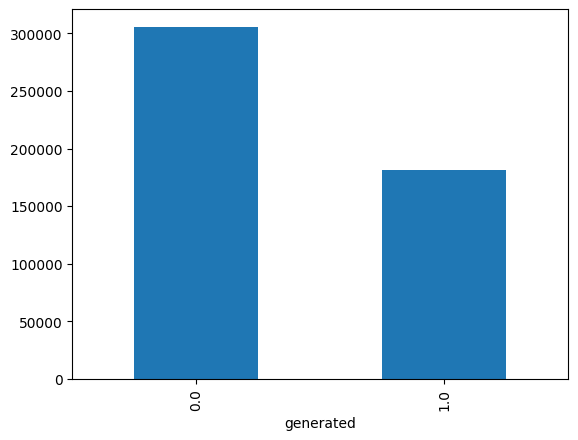

In [ ]:
import matplotlib.pyplot as plt

plt.plot(figsize=(10, 5))
# Plotting the distribution of the 'generated' column
df["generated"].value_counts().plot(kind="bar")
plt.show()

It is evident that most of the data is inclinde towards getting human-text rather than AI-generated

One of the other things I wanted to explore, what is the distribution of text lengths, so we can look into anomalies and see how the models would deal with that, so i'll be looking into it next

Text(0.5, 1.0, 'Distribution of Text Lengths')

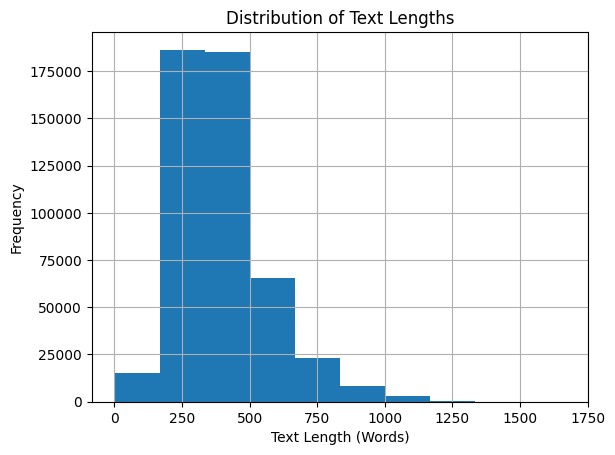

In [ ]:
# text length distribution
df["text_len_words"] = df["text"].apply(lambda x: len(x.split()))
# Plotting the distribution of text lengths
df["text_len_words"].hist()

# Legends and lables
plt.xlabel("Text Length (Words)")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")


We have enough texts whos length are less than 250 words and then very less texts whose length are more than 1000, but between that, we have a lot of data points that correspond to it

# Imports for NLTK and text-preprocessing

In [ ]:
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Function to pre-process text

The idea here was to pre-process the text manually using NLTK, and inbuilt python function, but that was too costly in terms of time and compute and was leading to about 13-14 hours of pre-processing on my machine, so instead of using the custom function, I used the hyperparameters in the TF-IDF vectorizer

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas(desc="Preprocessing")

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # converting it to list of words
    text_list = [t for t in text.split()]
    # removing punctuation and stopwords
    text_list = [t for t in text_list if t not in string.punctuation]
    text_list = [word for word in text_list if word not in stopwords.words('english')]

    # joining the list back to a string
    text = " ".join(text_list)
    return text

# applying the preprocessing function to the 'text' column
df["text"] = df["text"].progress_apply(preprocess_text)

print(df["text"].head())


# TF-IDF Vectorizer

One of the tasks at hand is to convert the raw text, to vectors for the models to process them and make predictions, for this use case, I will be using TF-IDF vectorizer, which would not only convert but also pre-process the text, the following parameters helps me with that

- lowercase = True
- stop_words = "english"
- strip_accents = 'unicode'

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["generated"], test_size=0.2, random_state=42)

tfid = TfidfVectorizer(
    ngram_range=(1,2), # creats both unigrams and bigrams
    min_df=2, # ignores terms that appear in less than 2 documents
    max_df=0.9, # ignores terms that appear in more than 90% of the documents
    max_features=20000, # limits the number of features to 20,000
    lowercase=True, # converts all characters to lowercase
    stop_words="english", # removes English stop words
    strip_accents='unicode', # removes accents from characters
    )
X_train_tfid = tfid.fit_transform(X_train)
X_test_tfid = tfid.transform(X_test)

# The Baseline Models

I will be using two models, Logistic Regression and LinearSVC, and not Naive Bayes, because with Naive Bayes the issue is, our dataset is too large, a lot of features are there and Naive Bayes has an assumption that each feature is independent of the other, which might not work in this case, so I'll be exploring the following 

- Logistic Regression
- LinearSVC (Support Vector Classifier)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000) # large feature space so thats why I set the iterations to 1000
model.fit(X_train_tfid, y_train)

y_pred = model.predict(X_test_tfid)

In [ ]:
from sklearn.svm import LinearSVC

# Using LinearSVC for better performance on large feature spaces
model = LinearSVC()

model.fit(X_train_tfid, y_train)

y_pred_svc = model.predict(X_test_tfid)

# Evaluation Metrics

I have imported the evaluation metrics from the evaluation metrics file that I created, because most of the evaluation code was being used in other files as well, so wanted it to be more modular

In [ ]:
from evaluation_metrics import evaluate_model
print("Evaluating Logistic Regression Model")
evaluate_model(y_test, y_pred)

print()

print("Evaluating SVM Model")
evaluate_model(y_test, y_pred_svc)

Evaluating Logistic Regression Model
Accuracy: 0.9948997916816321
F1 Score: 0.9931346953434724
Precision: 0.9969493593654668
Recall: 0.9893491124260355

Evaluating SVM Model
Accuracy: 0.9988096093260952
F1 Score: 0.9984018516477461
Precision: 0.9995861954812546
Recall: 0.9972203109949085
